# Multi-Class Classification : Cloud classification

Data augmentation is used for training almost all image-based models. There are many advantages:
- Using data augmentation allows the model to learn from more examples
- Using data augmentation increases the diversity of the training data
- Data augmentation makes the model more robust to variations and distortions commonly found in real-world images
- Data augmentation reduces the risk of overfitting as the model learns to ignore the random transformations


### Using tensorflow to load and augment dataset

We will use tensorflow to load and augment the image dataset during loading to introduce feature invariance.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
import numpy as np

# Define paths
train_dir = 'kaggle/clouds_train'
test_dir = 'kaggle/clouds_test'

# Create ImageDataGenerators with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)
img_dim = 128
# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_dim, img_dim),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 460 images belonging to 7 classes.
Found 471 images belonging to 7 classes.


### Creating CNN model

We will now create a deep learning model that takes the images classify them

In [2]:

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(img_dim, img_dim, 3)),
    ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), padding='same'),
    ELU(alpha=1.0),
    # MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(512, (3, 3), padding='same'),
    # ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='elu'),
    Dense(7, activation='softmax')  # Assuming 7 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


Let us visualize how the model looks like. We will create a helper function for visualization of model structure and see summary of model parameters

In [3]:
# Import the plotting function
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def model_summary(model, model_name):
    # Summarize the model
    model.summary()

    # Plot the model
    plot_model(model, to_file=model_name)

    # Display the image
    data = plt.imread(model_name)
    plt.imshow(data)
    plt.show()

Let us now use this function to see our model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
elu (ELU)                    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
elu_1 (ELU)                  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

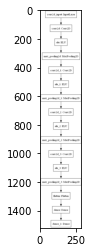

In [4]:
model_summary(model=model, model_name="model.png")


### Performance Evaluation

Let us now see how this model performs on test data

In [5]:

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(test_generator)

print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')


Epoch 1/10
15/15 [==============================] - 11s 745ms/step - loss: 3.4987 - accuracy: 0.2783 - precision: 0.3043 - recall: 0.1978 - val_loss: 2.2111 - val_accuracy: 0.1826 - val_precision: 0.3125 - val_recall: 0.0318
Epoch 2/10
15/15 [==============================] - 11s 739ms/step - loss: 1.4943 - accuracy: 0.4217 - precision: 0.5226 - recall: 0.2761 - val_loss: 1.8686 - val_accuracy: 0.2951 - val_precision: 0.4328 - val_recall: 0.2187
Epoch 3/10
15/15 [==============================] - 11s 763ms/step - loss: 1.2112 - accuracy: 0.5087 - precision: 0.6396 - recall: 0.3087 - val_loss: 1.8214 - val_accuracy: 0.3652 - val_precision: 0.5079 - val_recall: 0.1359
Epoch 4/10
15/15 [==============================] - 14s 913ms/step - loss: 1.0551 - accuracy: 0.5870 - precision: 0.7105 - recall: 0.4696 - val_loss: 1.5622 - val_accuracy: 0.4013 - val_precision: 0.4790 - val_recall: 0.2909
Epoch 5/10
15/15 [==============================] - 15s 1s/step - loss: 0.9797 - accuracy: 0.6522 - 

Let us see the per class performance (one vs rest classification concept) to see how the model performs in predicting the right class

In [6]:

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Print precision and recall per class
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {label} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-score: {metrics['f1-score']:.4f}")

Class cirriform clouds - Precision: 0.5000, Recall: 0.1343, F1-score: 0.2118
Class clear sky - Precision: 0.9333, Recall: 0.2188, F1-score: 0.3544
Class cumulonimbus clouds - Precision: 0.7273, Recall: 0.7273, F1-score: 0.7273
Class cumulus clouds - Precision: 0.9630, Recall: 0.2185, F1-score: 0.3562
Class high cumuliform clouds - Precision: 0.6700, Recall: 0.6505, F1-score: 0.6601
Class stratiform clouds - Precision: 0.1843, Recall: 1.0000, F1-score: 0.3113
Class stratocumulus clouds - Precision: 0.4578, Recall: 0.5672, F1-score: 0.5067


The macro average

In [7]:
report['macro avg']


{'precision': 0.6336760208721788,
 'recall': 0.5023554423481925,
 'f1-score': 0.4468116331414744,
 'support': 471.0}

And, the weighted average

In [8]:
report['weighted avg']

{'precision': 0.6855284429097825,
 'recall': 0.4288747346072187,
 'f1-score': 0.428117871675951,
 'support': 471.0}